<a href="https://colab.research.google.com/github/esmanurarslan/4th_grade_hw/blob/main/sna_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-louvain
!pip install community


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import random
from networkx.algorithms import bipartite
from networkx.algorithms.community import girvan_newman
import community
from community import community_louvain



## Dataset

In [ ]:
sampled_data=pd.read_csv('/content/drive/MyDrive/SNA Proje/sampled_data_updated.csv')

In [ ]:
sampled_data.head()

MovieID   UserID  Rank               title
0      241  2622042     4  North by Northwest
1      241   742858     4  North by Northwest
2      241  1675472     3  North by Northwest
3      241   322797     3  North by Northwest
4      241  2127544     2  North by Northwest

In [ ]:
#kaç kişi,kaç film
x=sampled_data["UserID"].nunique()
y=sampled_data["MovieID"].nunique()
print("Unique User:" ,x)
print("Unique Movie:" ,y)

Unique User: 80
Unique Movie: 55


## Bipartite Graph Görselleştirme

In [ ]:
# Yönlü bir graph (DiGraph) oluştur
C = nx.DiGraph()  # Yönlü grafiğe geçiş

# Kullanıcı ve film düğümlerini ekle
C.add_nodes_from(sampled_data["UserID"], bipartite=0)  # Kullanıcılar (0 seti)
C.add_nodes_from(sampled_data["MovieID"], bipartite=1)  # Filmler (1 seti)

# Yönlü kenarları ekle (Kullanıcı -> Film yönünde)
edges = list(zip(sampled_data["UserID"], sampled_data["MovieID"], sampled_data["Rank"]))
C.add_weighted_edges_from(edges)  # Rank ağırlık olarak eklenir

# Bipartite graph görselleştirme
def draw_bipartite_graph_with_legend(C, user_color="orange", movie_color="pink"):
    # Düğüm renklerini ayarla
    node_colors = [
        user_color if node in sampled_data["UserID"].values else movie_color
        for node in C.nodes()
    ]

    # Düğüm yerleşimi bipartite yapısına göre ayarlanır
    pos = nx.bipartite_layout(C, sampled_data["UserID"].values)

    # Graph çizimi
    plt.figure(figsize=(10, 20))
    nx.draw(
        C, pos, with_labels=True, node_size=200, node_color=node_colors,
        font_size=10, edge_color="gray", font_weight="bold", arrows=True  # Yönlü oklar için `arrows=True`
    )

    # Edge label ekleme
    edge_labels = {(u, v): d["weight"] for u, v, d in C.edges(data=True)}
    nx.draw_networkx_edge_labels(C, pos, edge_labels=edge_labels, font_size=8)

    # Legend ekleme
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Kullanıcı (User)',
               markersize=10, markerfacecolor=user_color),
        Line2D([0], [0], marker='o', color='w', label='Film (Movie)',
               markersize=10, markerfacecolor=movie_color)
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

    plt.title("Bipartite Directed Graph: Kullanıcılar ve Filmler")
    plt.show()

# Grafiği çiz
draw_bipartite_graph_with_legend(C)


## PathSim Benzerliği Hesaplama

In [ ]:
def calculate_pathsim(B, node1, node2):
    """
    PathSim benzerliğini, iki düğüm arasındaki ortak yolları ve yol uzunluklarını kullanarak hesaplar.

    Parameters:
    - B: Heterojen ağ (bipartite graph)
    - node1, node2: Benzerliği hesaplamak istediğiniz düğümler

    Returns:
    - pathsim_score: PathSim benzerliği
    """
    # node1 ve node2 arasında tüm en kısa yolları bul
    paths = list(nx.all_shortest_paths(B, source=node1, target=node2))

    if len(paths) == 0:
        return 0  # Eğer ortak yol yoksa, benzerlik sıfırdır

    # En kısa yol uzunluğu
    min_path_length = len(paths[0])

    # Ortak yolları hesapla (ilk yolun her adımını inceleyelim)
    common_steps = 0
    for path in paths:
        # Her bir yol üzerinde kesişen adımları say
        common_steps += len(set(path) & set(paths[0]))

    # PathSim değerini, ortak adımların sayısını yol sayısına bölerek hesaplayalım
    pathsim_score = common_steps / min_path_length

    return pathsim_score

# Örnek olarak iki düğüm (kullanıcı ve film) arasındaki benzerliği hesaplayalım
node1 = sampled_data["UserID"].values[0]  # İlk kullanıcı
node2 = sampled_data["MovieID"].values[0]  # İlk film

pathsim_value = calculate_pathsim(C, node1, node2)
print(f"PathSim({node1}, {node2}) = {pathsim_value:.4f}")

## Directed Graph: Kullanıcılar ve Filmler (Edge Kalınlığı Sabit)

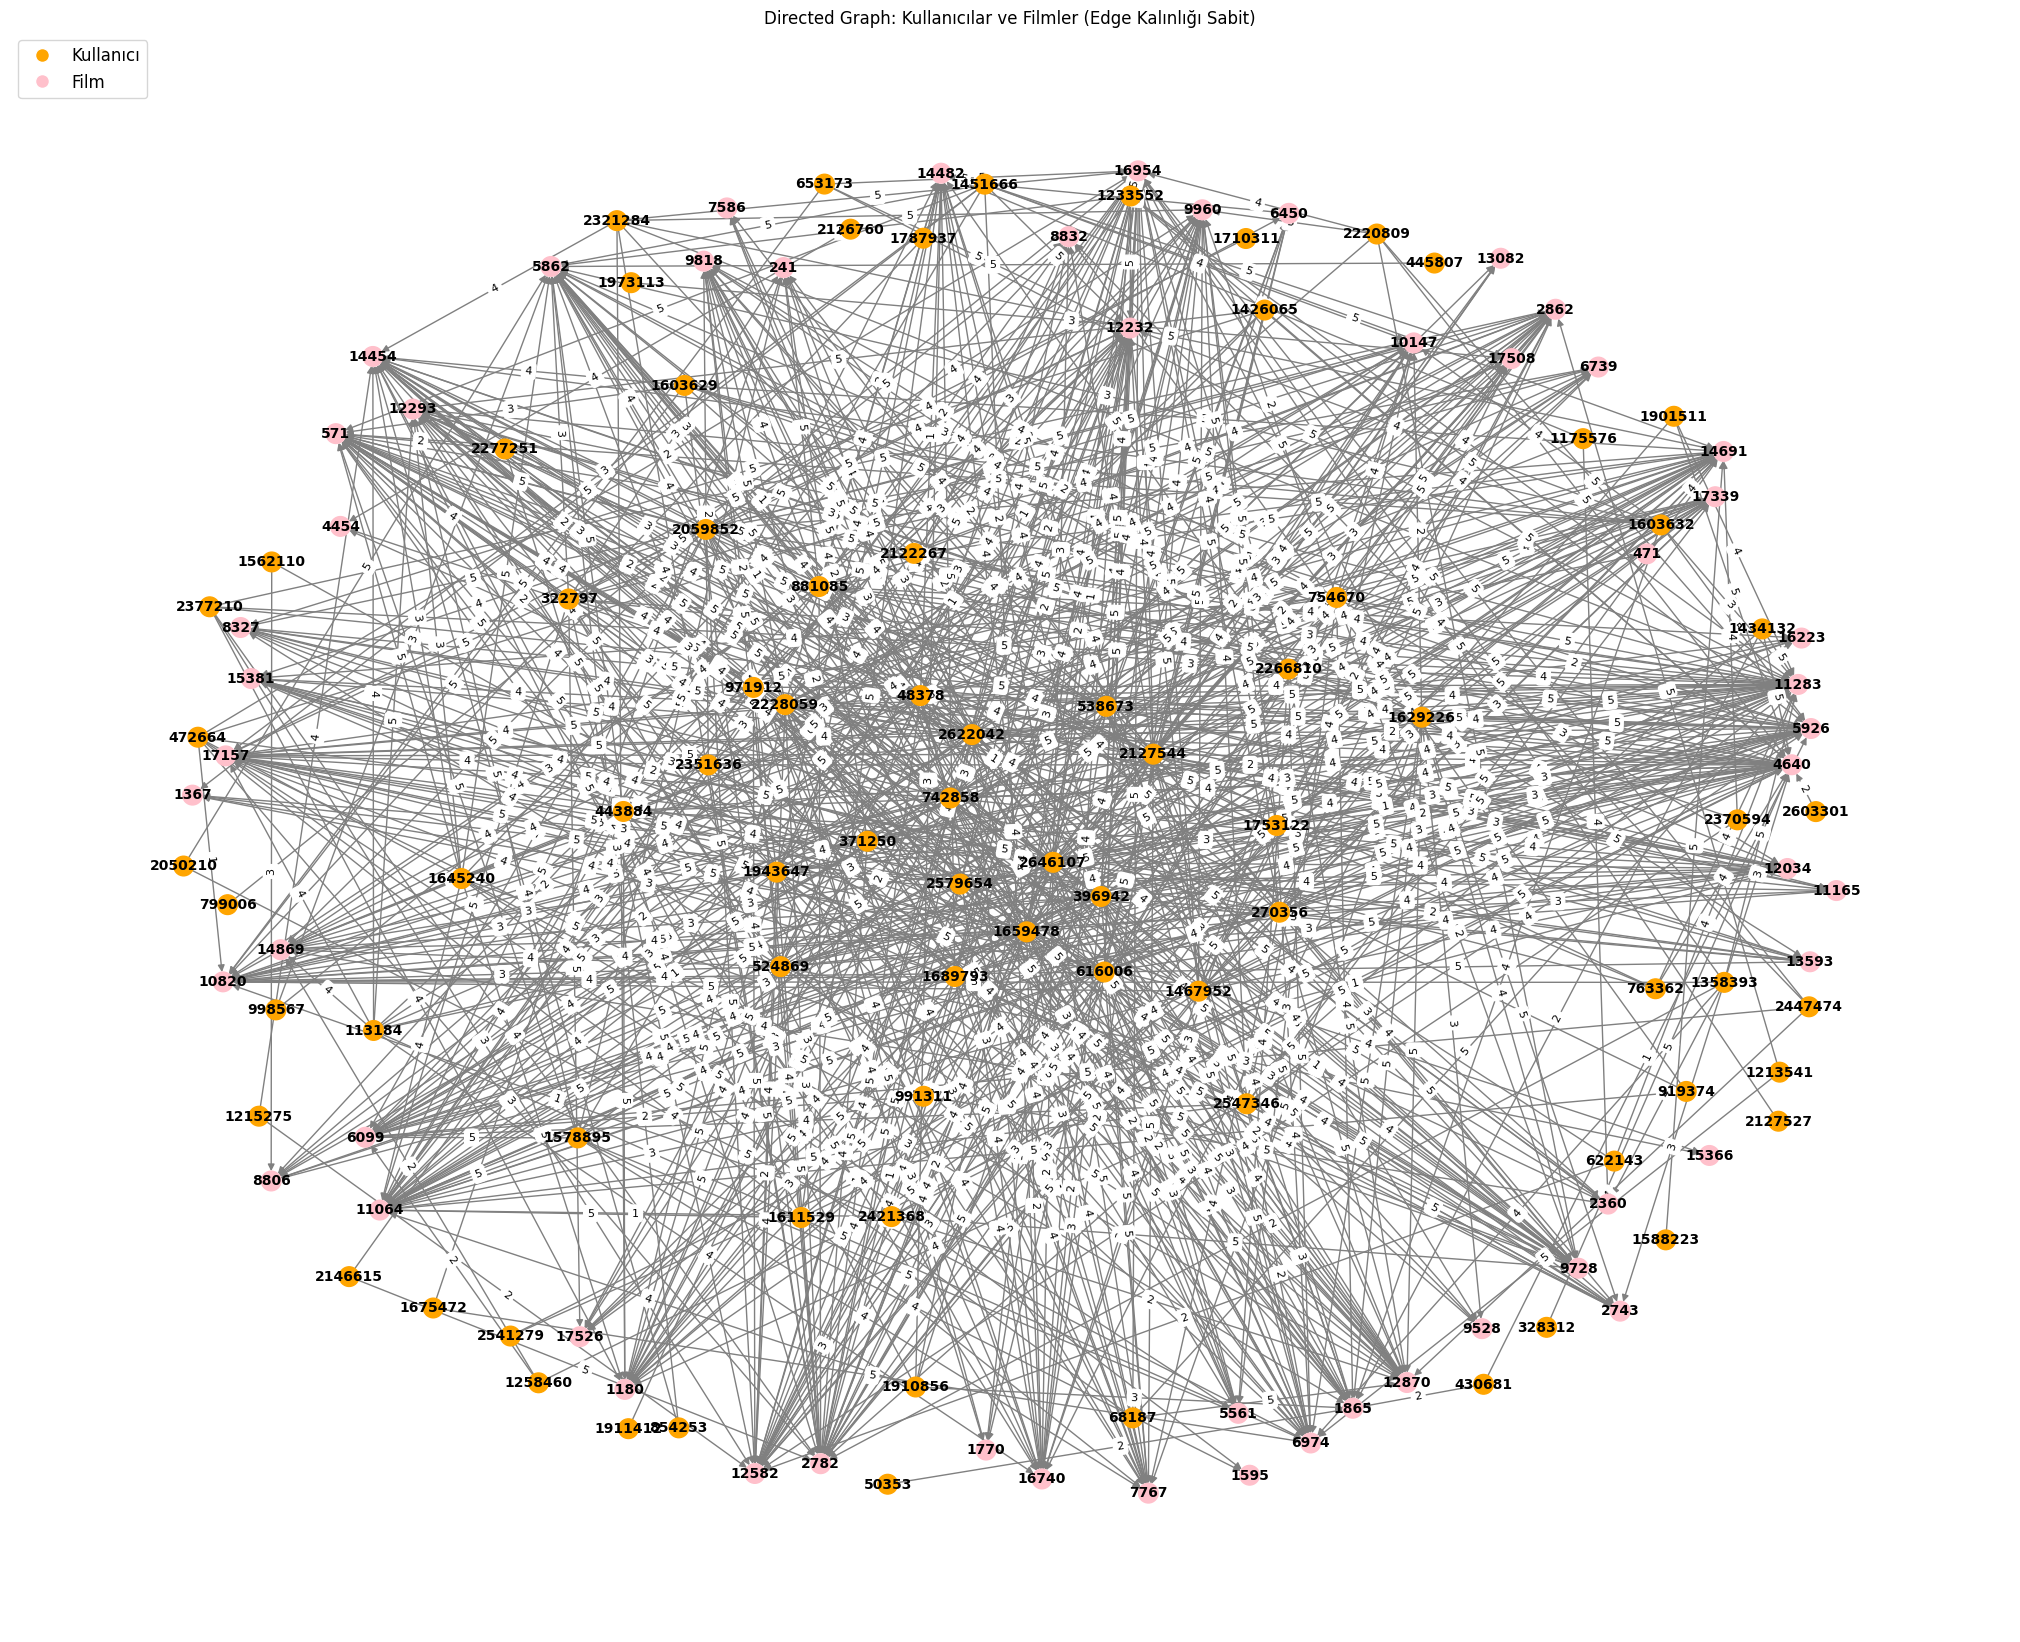

In [ ]:
# Yönlü Graph oluştur
H = nx.DiGraph()

# Kullanıcılar ve filmler için düğümleri ekleme
H.add_nodes_from(sampled_data["UserID"], bipartite=0)  # Kullanıcılar (0 seti)
H.add_nodes_from(sampled_data["MovieID"], bipartite=1)  # Filmler (1 seti)

# Yönlü kenarları ve ağırlıkları ekleme
edges = list(zip(sampled_data["UserID"], sampled_data["MovieID"], sampled_data["Rank"]))
H.add_weighted_edges_from(edges)  # Rank değeri ağırlık olarak eklenir

def draw_directed_graph_no_thick_edges(H, user_color="orange", movie_color="pink", k=0.3):
    # Düğüm renklerini ayarlama
    node_colors = [
        user_color if node in sampled_data["UserID"].values else movie_color
        for node in H.nodes()
    ]

    # Kenar ağırlıklarını ters çevirerek mesafeye uyarlama
    edge_weights = nx.get_edge_attributes(H, "weight")
    inverted_weights = {edge: 1 / weight if weight > 0 else 1 for edge, weight in edge_weights.items()}
    nx.set_edge_attributes(H, inverted_weights, "inverted_weight")

    # Spring layout ile düğüm yerleşimi (ağırlıkları kullanarak)
    pos = nx.spring_layout(H, seed=42, weight="inverted_weight", k=k)

    # Grafik çizimi (yönlü oklarla)
    plt.figure(figsize=(20, 16))
    nx.draw(
        H, pos, with_labels=True, node_size=200, node_color=node_colors,
        font_size=10, edge_color="gray", font_weight="bold", arrows=True  # Yönlü oklar için arrows=True
    )

    # Kenar etiketlerini ekleyelim (Rank değeri)
    edge_labels = {(u, v): d["weight"] for u, v, d in H.edges(data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=8)

    # Legend ekleme
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Kullanıcı',
               markersize=10, markerfacecolor=user_color),
        Line2D([0], [0], marker='o', color='w', label='Film',
               markersize=10, markerfacecolor=movie_color)
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

    plt.title("Directed Graph: Kullanıcılar ve Filmler (Edge Kalınlığı Sabit)")
    plt.show()

# Grafiği çizelim
draw_directed_graph_no_thick_edges(H, k=1.0)




In [ ]:
# Grafikteki toplam node sayısını ve kenar sayısını yazdırma
total_nodes = H.number_of_nodes()
total_edges = H.number_of_edges()
print(f"Total nodes: {total_nodes}")
print(f"Total edges: {total_edges}")

Total nodes: 135
Total edges: 929


## Dereceler

In [ ]:
# Kullanıcılar ve filmleri grafikteki düğüm türüne göre ayırt etme
users = {node for node, data in H.nodes(data=True) if data.get("bipartite") == 0}
movies = {node for node, data in H.nodes(data=True) if data.get("bipartite") == 1}

# Kullanıcıların out-degree değerleri
user_out_degrees = {node: degree for node, degree in H.out_degree(users)}

# Filmlerin in-degree değerleri
movie_in_degrees = {node: degree for node, degree in H.in_degree(movies)}

# En yüksek out-degree değerine sahip kullanıcı
top_user = max(user_out_degrees, key=user_out_degrees.get)
top_user_degree = user_out_degrees[top_user]

# En yüksek in-degree değerine sahip film
top_movie = max(movie_in_degrees, key=movie_in_degrees.get)
top_movie_degree = movie_in_degrees[top_movie]

# Sonuçları yazdırma
print(f"En yüksek çıkış derecesine sahip kullanıcı: {top_user} (Derece: {top_user_degree})")
print(f"En yüksek giriş derecesine sahip film: {top_movie} (Derece: {top_movie_degree})")

En yüksek çıkış derecesine sahip kullanıcı: 1659478 (Derece: 45)
En yüksek giriş derecesine sahip film: 11283 (Derece: 42)


In [ ]:

# In-degree (film alıcıları)
in_degree_centrality = nx.in_degree_centrality(H)

# Out-degree (kullanıcı bağlantıları)
out_degree_centrality = nx.out_degree_centrality(H)

# En yüksek in-degree değerine sahip film
top_movie = max(in_degree_centrality, key=in_degree_centrality.get)
top_movie_id = top_movie  # Film ID
top_movie_title = sampled_data[sampled_data["MovieID"] == top_movie_id]["title"].values[0]  # Film Başlığı

# En yüksek out-degree değerine sahip kullanıcı
top_user = max(out_degree_centrality, key=out_degree_centrality.get)

# Sonuçları yazdırma
print(f"En yüksek dereceye sahip kullanıcı: {top_user} (Derece merkezliği: {out_degree_centrality[top_user]})")
print(f"En yüksek dereceye sahip film: {top_movie} (Derece merkezliği: {in_degree_centrality[top_movie]})")
print(f"En yüksek dereceye sahip filmin adı: {top_movie_title}")

En yüksek dereceye sahip kullanıcı: 1659478 (Derece merkezliği: 0.33582089552238803)
En yüksek dereceye sahip film: 11283 (Derece merkezliği: 0.31343283582089554)
En yüksek dereceye sahip filmin adı: Forrest Gump


## Film Popülerliği Ölçümü

In [ ]:
#filmlerin popülerliğini ölçer
# PageRank algoritması kullanılarak filmlere ait PageRank hesaplanır
pagerank_movies = nx.pagerank(H, alpha=0.85)

# En yüksek PageRank değerlerine sahip ilk 5 filmi bulalım
sorted_pagerank_movies = sorted(pagerank_movies.items(), key=lambda x: x[1], reverse=True)
# sampled_data içindeki 'MovieID' ve 'title' kolonundan başlıkları almak için
movie_titles = {row['MovieID']: row['title'] for _, row in sampled_data.iterrows()}

print("En yüksek PageRank değerine sahip 5 film:")
for movie_id, score in sorted_pagerank_movies[:5]:
    title = movie_titles.get(movie_id, "Bilinmeyen Film")  # Film başlığını al
    print(f"Film Başlığı: {title}, Film ID: {movie_id}, PageRank: {score}")

En yüksek PageRank değerine sahip 5 film:
Film Başlığı: Rain Man, Film ID: 4640, PageRank: 0.02930991284184579
Film Başlığı: Forrest Gump, Film ID: 11283, PageRank: 0.02545059429110981
Film Başlığı: Indiana Jones and the Last Crusade, Film ID: 16954, PageRank: 0.024602914481897983
Film Başlığı: Memento, Film ID: 5862, PageRank: 0.019824462565646565
Film Başlığı: Braveheart, Film ID: 2782, PageRank: 0.018617030022947022


## Topluluk Algılama

In [ ]:
# fast_label_propagation_communities  is used because label_propagation_communities does not work on directed graphs.
communities = list(nx.algorithms.community.fast_label_propagation_communities(H))

# Sonuçları yazdıralım
for i, community in enumerate(communities):
    print(f"Community {i}: {community}")


Community 0: {9728, 12293, 15366, 11283, 2351636, 1434132, 270356, 14869, 1175576, 15381, 2122267, 113184, 1787937, 1753122, 2370594, 4640, 1629226, 1603629, 1467952, 538673, 371250, 1603632, 1358393, 16954, 571, 1595, 622143, 10820, 524869, 616006, 12870, 1910856, 2059852, 991311, 6739, 1659478, 7767, 472664, 430681, 2622042, 2646107, 68187, 9818, 1943647, 17508, 1213541, 8806, 2447474, 1911412, 14454, 17526, 328312, 2421368, 8832, 8327, 971912, 396942, 1233552, 1426065, 1451666, 2547346, 14482, 1180, 2050210, 998567, 2127527, 50353, 2743, 1645240, 2127544, 2266810, 1689793, 2579654, 1675472, 2782, 2541279, 5862, 1710311, 9960, 1770, 322797, 854253, 241, 48378, 12034, 17157, 2220809, 1611529, 13593, 13082, 799006, 2603301, 5926, 12582, 1215275, 2862, 6450, 2146615, 2360, 9528, 11064, 6974, 1865, 919374, 1367, 2228059, 16223, 14691, 16740, 4454, 445807, 653173, 1973113, 2277251, 2321284, 1578895, 11165, 7586, 10147, 2126760, 5561, 17339, 881085, 1901511, 12232, 742858, 6099, 471, 12584

In [ ]:
# Kullanıcı- film matrisi oluşturuyoruz (her satırda bir kullanıcı, her sütunda bir film var)
user_movie_matrix = sampled_data.pivot_table(index="UserID", columns="MovieID", values="Rank", fill_value=0)

In [ ]:
# Kullanıcılar arası benzerlik hesaplaması: Kosinüs Benzerliği
user_similarity = cosine_similarity(user_movie_matrix)

In [ ]:
# Cosine Similarity ile filmler arası benzerlik hesaplanıyor (Item-based Recommendation)
item_similarity = cosine_similarity(user_movie_matrix.T)
movie_similarity=item_similarity

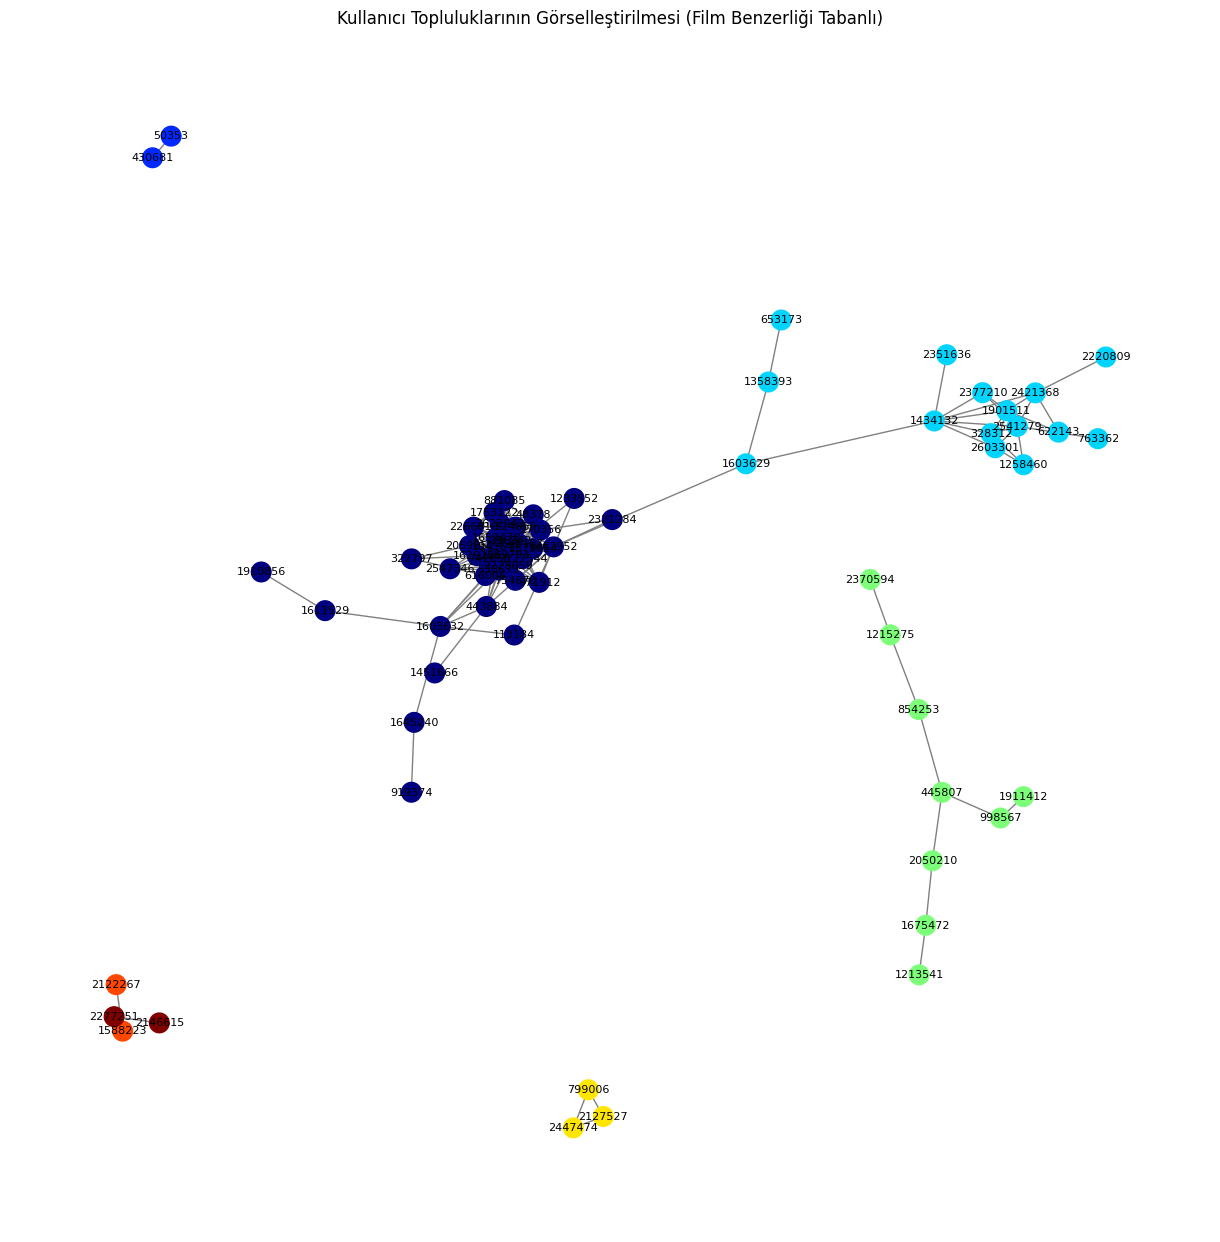

In [ ]:

# Kullanıcılar arası benzerliği görselleştirebilmek için bir graf oluşturuyoruz
G = nx.Graph()

# Kullanıcılar arasındaki kenarları ekliyoruz
num_users = len(user_movie_matrix)
for i in range(num_users):
    for j in range(i+1, num_users):
        similarity_score = user_similarity[i, j]
        if similarity_score > 0.55:  # Benzerlik eşiği
            G.add_edge(user_movie_matrix.index[i], user_movie_matrix.index[j], weight=similarity_score)

# Kullanıcıları kümeliyoruz: Topluluk algılama
from networkx.algorithms.community import girvan_newman
communities = list(girvan_newman(G))

# Kullanıcıları kümelendiriyoruz
communities = communities[0]  # Girvan-Newman algoritması birden fazla topluluk döndürebilir, ilkini seçiyoruz.

# Kümelenmiş kullanıcıları görselleştirelim
def draw_user_communities(G, communities):
    # Topluluklar için renkler
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i

    # Düğüm yerleşimi (spring layout)
    pos = nx.spring_layout(G, seed=42)  # Yerleşim metodunu buraya uyguluyoruz

    # Düğümleri çiz
    node_colors = [color_map[node] for node in G.nodes()]
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_size=200, node_color=node_colors, with_labels=True, font_size=8, cmap=plt.cm.jet, edge_color="gray")

    # Başlık ve gösterim
    plt.title("Kullanıcı Topluluklarının Görselleştirilmesi (Film Benzerliği Tabanlı)")
    plt.show()

# Kümeleri görselleştirelim
draw_user_communities(G, communities)

In [ ]:
# Articulation points (kırılgan düğümler) tespiti
articulation_points = list(nx.articulation_points(G))

# Sonuç: Grafı iki parçaya bölecek düğüm
print(f"Grafı iki parçaya bölecek düğümler: {articulation_points}")

Grafı iki parçaya bölecek düğümler: [443884, 1611529, 1603632, 1645240, 1358393, 1603629, 2541279, 2421368, 1434132, 1467952, 1215275, 854253, 998567, 1675472, 2050210, 445807]


In [ ]:
##yukarıdaki graftan bilgiyi ulaştıran node gibi yorumlar yapılabilir

## User-User Graph: Ortak Film İzleme Ağı

User-User Graph - Düğüm Sayısı: 80
User-User Graph - Kenar Sayısı: 2101
User-User Graph - Yoğunluk: 0.664873417721519


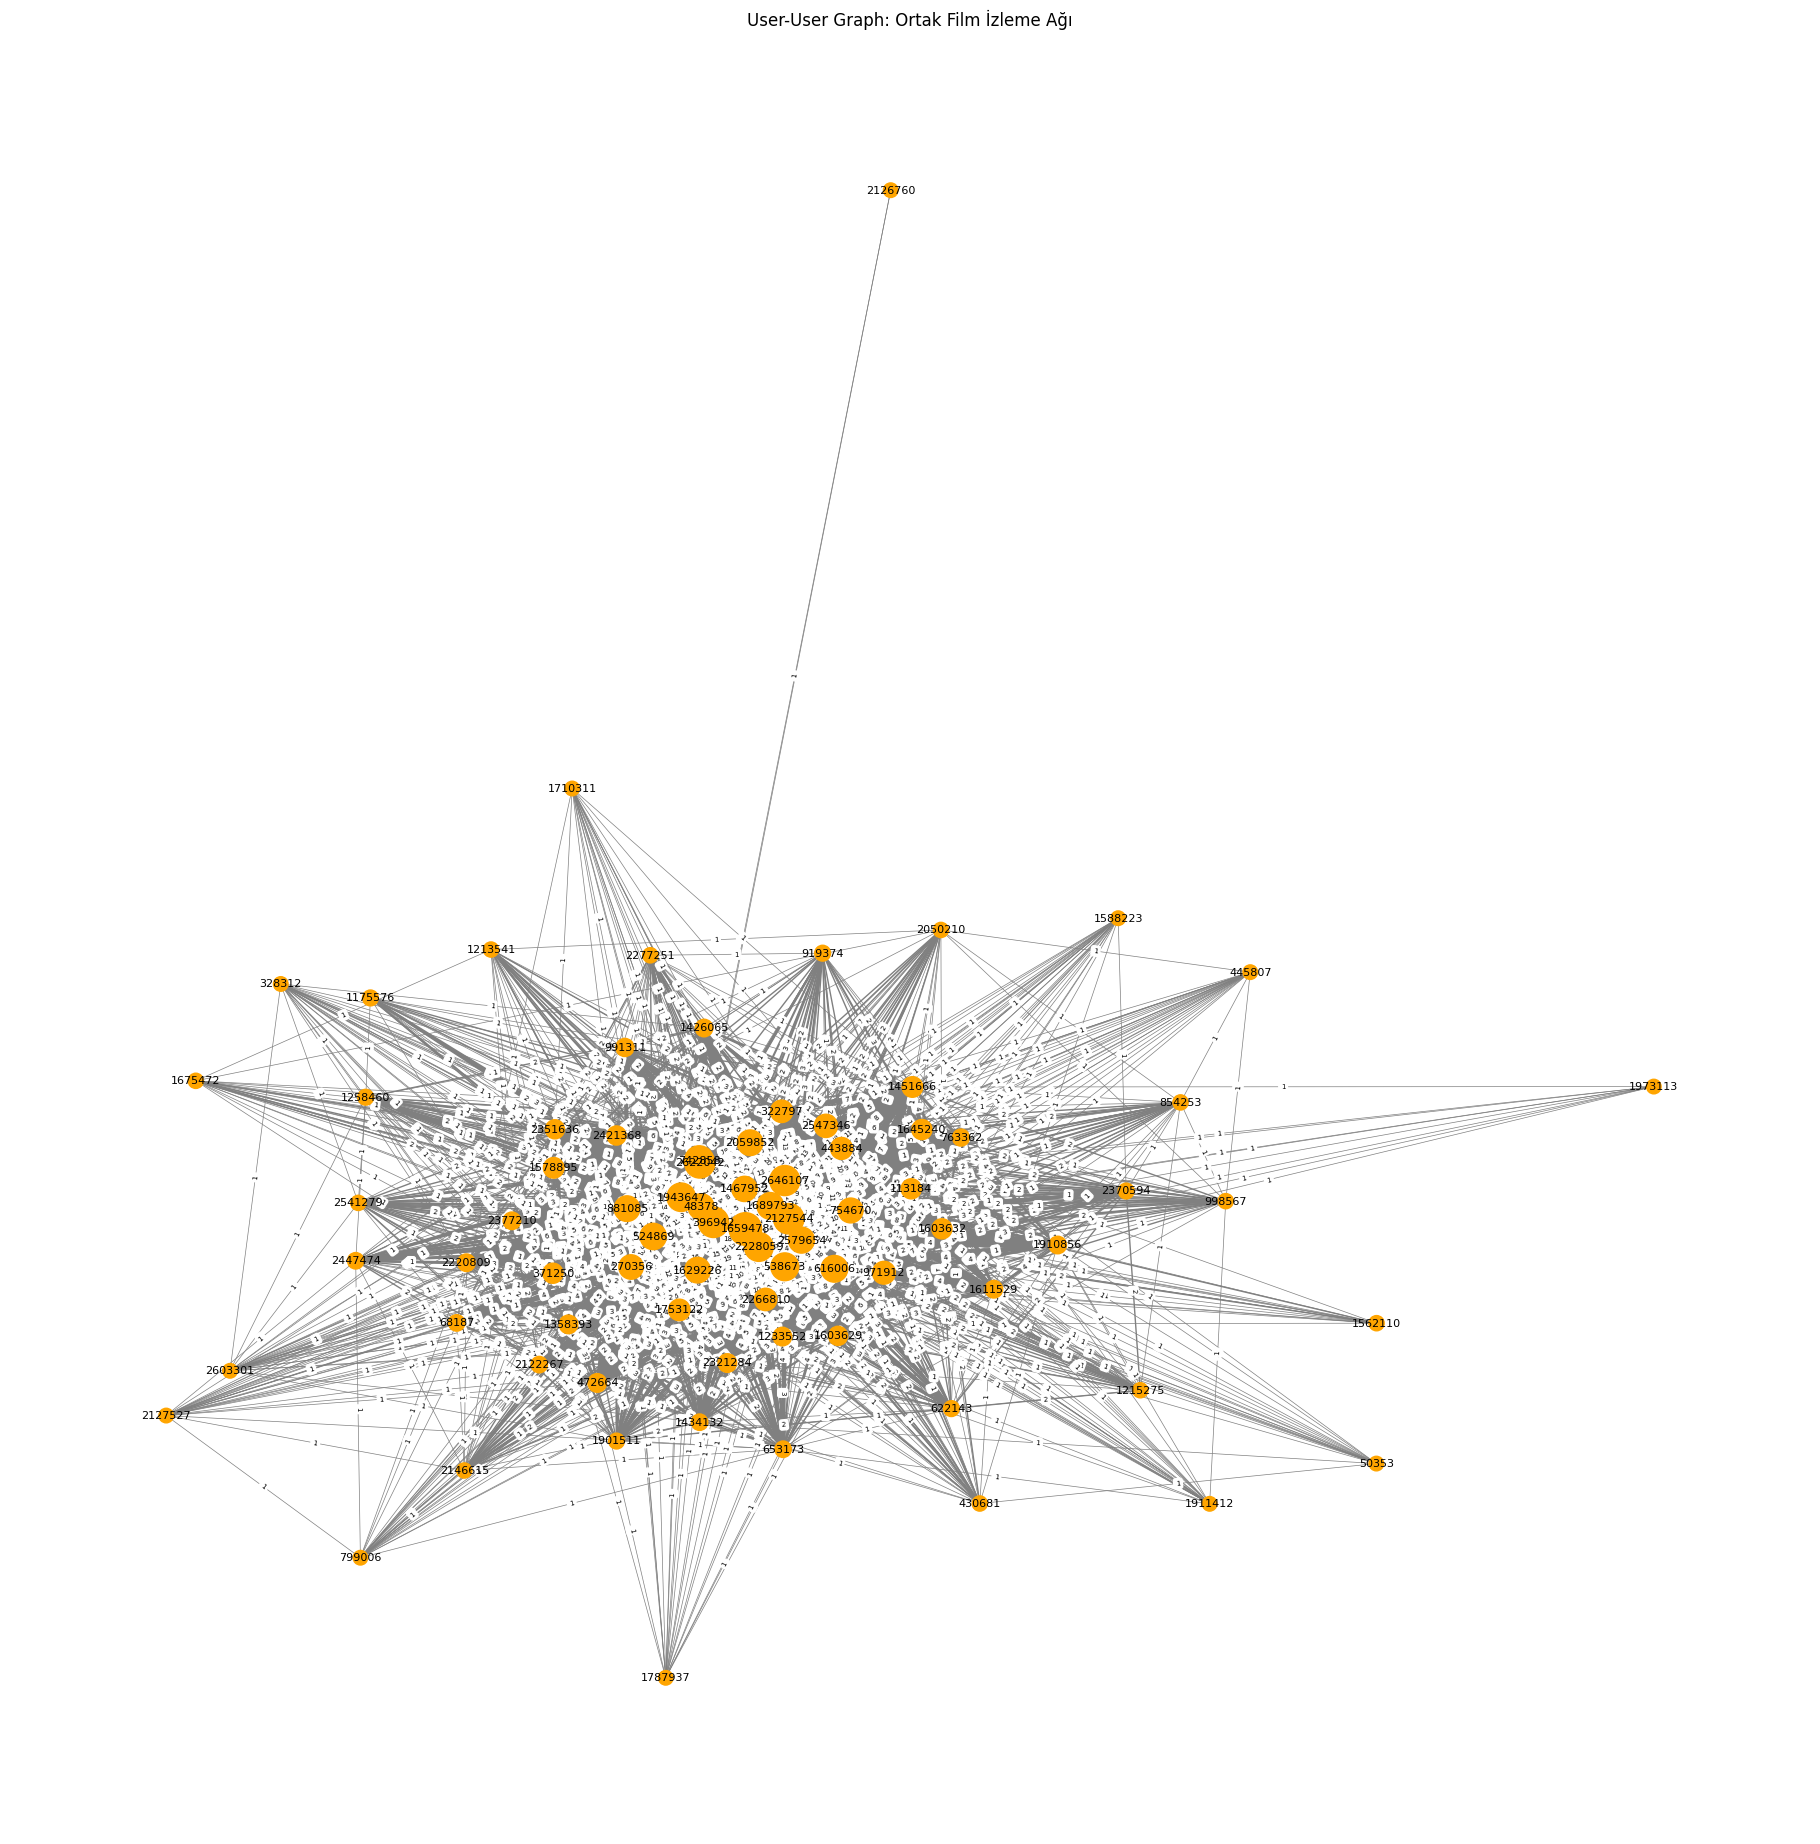

In [ ]:
# Kullanıcılar arasında ortak izlenen filmlerle bağlantı kurmak için bir bipartite grafik oluşturuluyor
B = nx.Graph()

# Kullanıcılar ve filmler için düğümler ekleniyor
B.add_nodes_from(sampled_data['MovieID'], bipartite=0)  # Film düğümleri
B.add_nodes_from(sampled_data['UserID'], bipartite=1)   # Kullanıcı düğümleri

# Kullanıcılar ve filmler arasındaki kenarları (edge) ekliyoruz
for _, row in sampled_data.iterrows():
    B.add_edge(row['UserID'], row['MovieID'], weight=row['Rank'])  # Filmdeki rank'ı kenar ağırlığı olarak ekliyoruz

# Kullanıcılar arasındaki ortak film sayısını hesaplayarak yeni bir graf oluşturuyoruz
user_graph = nx.Graph()

# Kullanıcılar arasındaki ortak izlenen filmler sayısını hesapla
for user1 in sampled_data['UserID'].unique():
    for user2 in sampled_data['UserID'].unique():
        if user1 != user2:
            # Kullanıcı1 ve Kullanıcı2 arasında ortak filmleri bul
            common_movies = set(B.neighbors(user1)).intersection(B.neighbors(user2))
            if common_movies:
                # Ortak filmleri sayarak edge ağırlığını belirle
                edge_weight = len(common_movies)
                user_graph.add_edge(user1, user2, weight=edge_weight)

# User-User grafiği hakkında bazı bilgiler
print(f"User-User Graph - Düğüm Sayısı: {user_graph.number_of_nodes()}")
print(f"User-User Graph - Kenar Sayısı: {user_graph.number_of_edges()}")
print(f"User-User Graph - Yoğunluk: {nx.density(user_graph)}")

plt.figure(figsize=(18, 18))  # Daha büyük bir grafik alanı

# Kullanıcılar arasındaki kenarları daha iyi yerleştirmek için spring layout ile düzenlemeleri artırıyoruz
pos = nx.spring_layout(user_graph, seed=42, k=0.15, iterations=50)

# Ağı daha belirgin hale getirmek için düğüm boyutlarını ve kenar kalınlıklarını ayarlıyoruz
node_size = [100 + 10 * len(list(B.neighbors(n))) for n in user_graph.nodes()]
edge_width = [d['weight'] * 0.5 for _, _, d in user_graph.edges(data=True)]

# Kullanıcı düğümlerini çizebiliriz (renkleri kullanıcıya özgü ayarlayabiliriz)
node_colors = ["orange" for _ in user_graph.nodes()]

# Ağı çiz
nx.draw(user_graph, pos, with_labels=True, node_size=node_size, node_color=node_colors, font_size=8, edge_color="gray", width=edge_width)

# Kenar ağırlıklarını (ortak film sayıları) göster
edge_labels = {(u, v): f"{d['weight']}" for u, v, d in user_graph.edges(data=True)}
nx.draw_networkx_edge_labels(user_graph, pos, edge_labels=edge_labels, font_size=5)

# Başlık
plt.title("User-User Graph: Ortak Film İzleme Ağı")
plt.show()

In [ ]:
#diameter,avarage length path,density hesaplama kodları yazmak lazım
print("User-User Graph Analizi:")
diameter = nx.diameter(user_graph)
print(f"Çap: {diameter}")
average_path_length = nx.average_shortest_path_length(user_graph)
print(f"Ortalama En kısa Yol Uzunluğu: {average_path_length}")
density = nx.density(user_graph)
print(f"Yoğunluk: {density}")

User-User Graph Analizi:
Çap: 3
Ortalama En kısa Yol Uzunluğu: 1.335759493670886
Yoğunluk: 0.664873417721519


In [ ]:
degree_centrality = nx.degree_centrality(user_graph)
print(degree_centrality)
# Degree merkeziyetini yazdır
print("Degree Centrality:")
print(degree_centrality)

# En yüksek degree merkeziyetine sahip düğüm ve değeri
max_centrality_node = max(degree_centrality, key=degree_centrality.get)
max_centrality_value = degree_centrality[max_centrality_node]

print(f"\nEn yüksek derece merkeziyeti olan düğüm: {max_centrality_node}")
print(f"En yüksek degree merkeziyet değeri: {max_centrality_value}")

{2622042: 0.9367088607594937, 742858: 0.9746835443037974, 1675472: 0.3291139240506329, 322797: 0.810126582278481, 2127544: 0.9746835443037974, 881085: 0.9240506329113924, 396942: 0.9746835443037974, 1578895: 0.7088607594936709, 371250: 0.7468354430379747, 48378: 0.8987341772151899, 1467952: 0.9493670886075949, 1689793: 0.9620253164556962, 538673: 0.9620253164556962, 1645240: 0.7341772151898734, 1659478: 0.9746835443037974, 2421368: 0.7721518987341772, 2059852: 0.8987341772151899, 1629226: 0.9367088607594937, 2646107: 0.9493670886075949, 919374: 0.5063291139240507, 443884: 0.8354430379746836, 2228059: 0.9746835443037974, 1603629: 0.8227848101265822, 2277251: 0.5189873417721519, 2579654: 0.9240506329113924, 1603632: 0.7974683544303798, 754670: 0.8607594936708861, 1451666: 0.7088607594936709, 524869: 0.8860759493670886, 1943647: 0.9620253164556962, 616006: 0.9240506329113924, 763362: 0.6708860759493671, 2351636: 0.7594936708860759, 971912: 0.8734177215189873, 2321284: 0.7594936708860759, 

In [ ]:
# Betweenness merkeziyetini hesapla
betweenness_centrality = nx.betweenness_centrality(user_graph)

# Betweenness merkeziyetini yazdır
print("Betweenness Centrality:")
print(betweenness_centrality)

# En yüksek betweenness merkeziyetine sahip düğüm ve değeri
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_betweenness_value = betweenness_centrality[max_betweenness_node]

print(f"\nEn yüksek betweenness merkeziyeti olan düğüm: {max_betweenness_node}")
print(f"En yüksek betweenness merkeziyet değeri: {max_betweenness_value}")


Betweenness Centrality:
{2622042: 0.02102155196455306, 742858: 0.024961216258595827, 1675472: 5.1410070805742506e-05, 322797: 0.003830489540306422, 2127544: 0.014632479973915966, 881085: 0.009288492503140837, 396942: 0.012741507938296122, 1578895: 0.002087387501386512, 371250: 0.0026032227836622584, 48378: 0.007977229315489772, 1467952: 0.011960201970184717, 1689793: 0.01191683588782051, 538673: 0.013149960193895523, 1645240: 0.0030203718471723713, 1659478: 0.012741507938296122, 2421368: 0.002746923928514329, 2059852: 0.00789850826500917, 1629226: 0.010274952688896888, 2646107: 0.011859993163328714, 919374: 0.0001720710079606832, 443884: 0.005529416061575493, 2228059: 0.014535877499780208, 1603629: 0.004500607398313735, 2277251: 0.00022723817953202585, 2579654: 0.008735916334340031, 1603632: 0.0040605999977215874, 754670: 0.007992998652459516, 1451666: 0.004662963458837216, 524869: 0.00706690839593875, 1943647: 0.01150653546145171, 616006: 0.011863128643495301, 763362: 0.00094343641069

In [ ]:
# Closeness merkeziyetini hesapla
closeness_centrality = nx.closeness_centrality(user_graph)

# Closeness merkeziyetini yazdır
print("Closeness Centrality:")
print(closeness_centrality)

# En yüksek closeness merkeziyetine sahip düğüm ve değeri
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
max_closeness_value = closeness_centrality[max_closeness_node]

print(f"\nEn yüksek closeness merkeziyeti olan düğüm: {max_closeness_node}")
print(f"En yüksek closeness merkeziyet değeri: {max_closeness_value}")


Closeness Centrality:
{2622042: 0.9404761904761905, 742858: 0.9753086419753086, 1675472: 0.5984848484848485, 322797: 0.8404255319148937, 2127544: 0.9753086419753086, 881085: 0.9294117647058824, 396942: 0.9753086419753086, 1578895: 0.7745098039215687, 371250: 0.797979797979798, 48378: 0.9080459770114943, 1467952: 0.9518072289156626, 1689793: 0.9634146341463414, 538673: 0.9634146341463414, 1645240: 0.79, 1659478: 0.9753086419753086, 2421368: 0.8144329896907216, 2059852: 0.9080459770114943, 1629226: 0.9404761904761905, 2646107: 0.9518072289156626, 919374: 0.6694915254237288, 443884: 0.8586956521739131, 2228059: 0.9753086419753086, 1603629: 0.8494623655913979, 2277251: 0.6752136752136753, 2579654: 0.9294117647058824, 1603632: 0.8315789473684211, 754670: 0.8777777777777778, 1451666: 0.7745098039215687, 524869: 0.8977272727272727, 1943647: 0.9634146341463414, 616006: 0.9294117647058824, 763362: 0.7523809523809524, 2351636: 0.8061224489795918, 971912: 0.8876404494382022, 2321284: 0.8061224489

In [ ]:
# Eigenvector merkeziyetini hesapla
eigenvector_centrality = nx.eigenvector_centrality(user_graph)

# Eigenvector merkeziyetini yazdır
print("Eigenvector Centrality:")
print(eigenvector_centrality)

# En yüksek eigenvector merkeziyetine sahip düğüm ve değeri
max_eigenvector_node = max(eigenvector_centrality, key=eigenvector_centrality.get)
max_eigenvector_value = eigenvector_centrality[max_eigenvector_node]

print(f"\nEn yüksek eigenvector merkeziyeti olan düğüm: {max_eigenvector_node}")
print(f"En yüksek eigenvector merkeziyet değeri: {max_eigenvector_value}")


Eigenvector Centrality:
{2622042: 0.14031855916511848, 742858: 0.14285578241901498, 1675472: 0.058486089687123995, 322797: 0.12980112935672036, 2127544: 0.14329503986798478, 881085: 0.13991507871773862, 396942: 0.14384605683562032, 1578895: 0.11670100559273637, 371250: 0.12231734393885335, 48378: 0.13770132867294146, 1467952: 0.14192695447482248, 1689793: 0.14285885165041723, 538673: 0.1427043952064562, 1645240: 0.11848488012890977, 1659478: 0.14384605683562032, 2421368: 0.12605560559064907, 2059852: 0.1376517355376677, 1629226: 0.14087723859151952, 2646107: 0.14201429947903588, 919374: 0.08893059451556957, 443884: 0.13054051565131683, 2228059: 0.14338238487219818, 1603629: 0.13084591850678046, 2277251: 0.09125988923774148, 2579654: 0.14048993960031986, 1603632: 0.12743820778457893, 754670: 0.13354535332359996, 1451666: 0.11268348599020153, 524869: 0.13675799550838383, 1943647: 0.14311796709957153, 616006: 0.13837729163026866, 763362: 0.11382626798320984, 2351636: 0.12299504363105174, 

In [ ]:
# Articulation points (kırılgan düğümler) tespiti
articulation_points = list(nx.articulation_points(user_graph))

# Sonuç: Grafı iki parçaya bölecek düğüm
print(f"Grafı iki parçaya bölecek düğümler: {articulation_points}")

Grafı iki parçaya bölecek düğümler: []


Topluluklar: {2622042: 1, 742858: 1, 1675472: 0, 322797: 1, 2127544: 1, 881085: 2, 396942: 1, 1578895: 1, 371250: 2, 48378: 1, 1467952: 0, 1689793: 1, 538673: 0, 1645240: 0, 1659478: 1, 2421368: 2, 2059852: 1, 1629226: 1, 2646107: 1, 919374: 1, 443884: 0, 2228059: 1, 1603629: 2, 2277251: 2, 2579654: 1, 1603632: 0, 754670: 1, 1451666: 0, 524869: 2, 1943647: 1, 616006: 1, 763362: 2, 2351636: 2, 971912: 0, 2321284: 2, 2547346: 0, 2377210: 2, 1426065: 1, 430681: 0, 1910856: 0, 1434132: 2, 991311: 1, 1175576: 1, 1358393: 2, 1562110: 1, 2266810: 2, 270356: 2, 1753122: 2, 2146615: 2, 472664: 2, 2122267: 2, 1213541: 2, 2126760: 1, 1258460: 1, 2541279: 2, 1901511: 2, 1233552: 0, 328312: 2, 2603301: 2, 2220809: 2, 854253: 0, 998567: 0, 445807: 0, 2050210: 0, 1611529: 0, 113184: 0, 2447474: 1, 653173: 2, 622143: 2, 68187: 2, 2370594: 0, 1215275: 0, 799006: 2, 2127527: 2, 1710311: 1, 50353: 0, 1787937: 2, 1911412: 0, 1588223: 0, 1973113: 0}
Community 1 üyeleri: [2622042, 742858, 322797, 2127544, 3

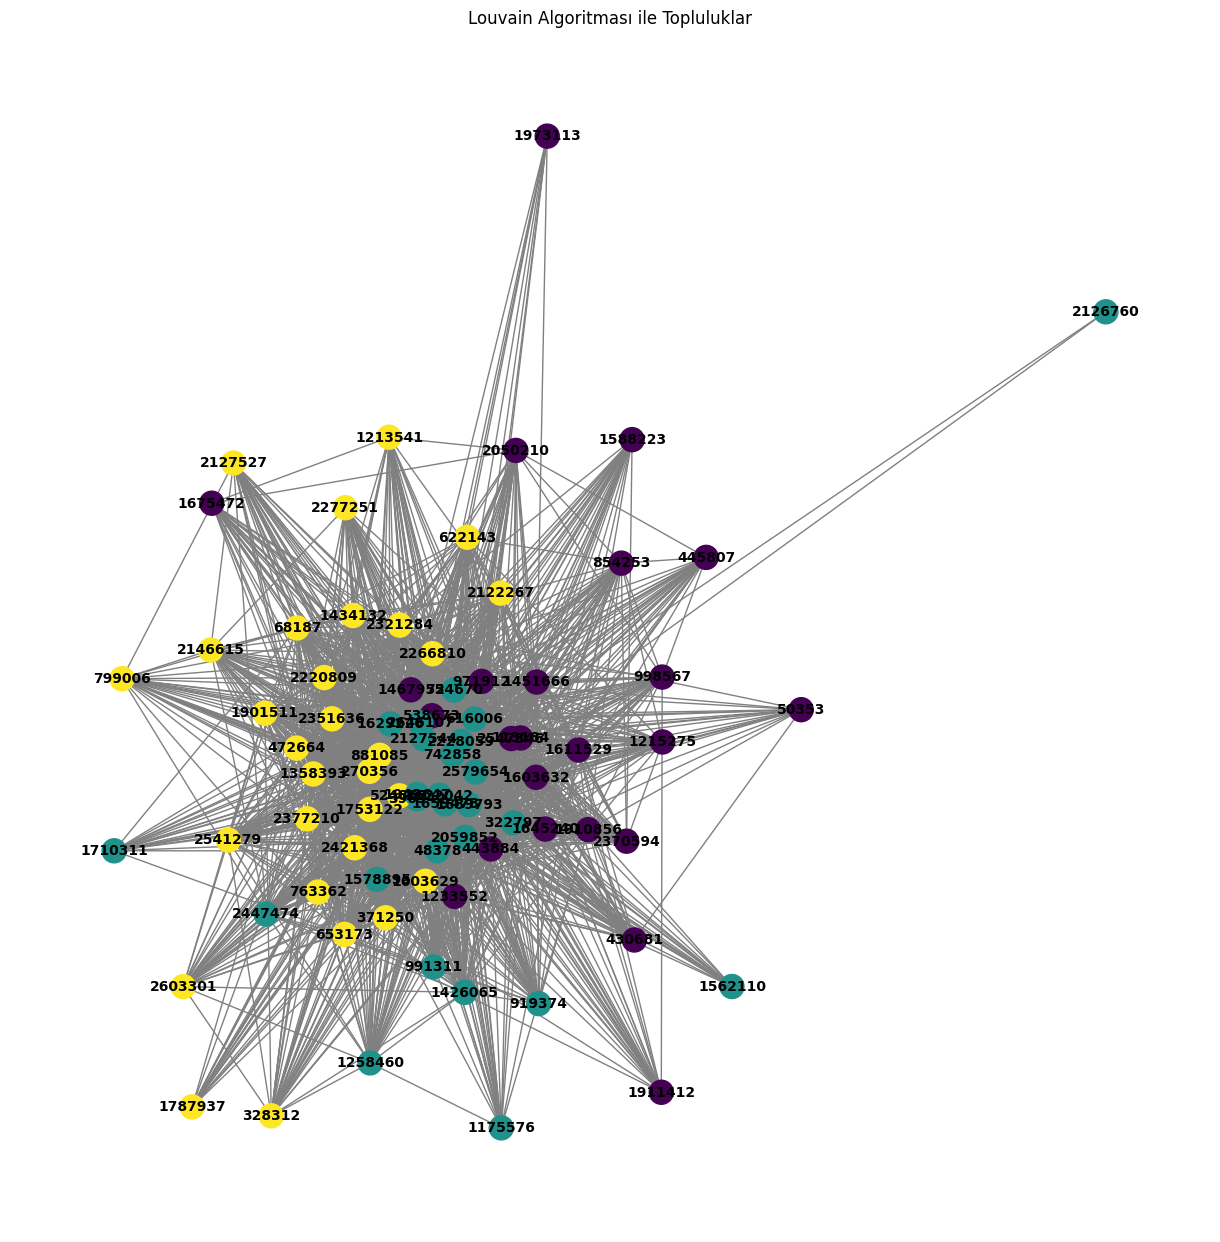

In [ ]:
# Louvain algoritması ile toplulukları tespit et
partition = community_louvain.best_partition(user_graph) # Use community_louvain here

# Toplulukları yazdır
print(f"Topluluklar: {partition}")
# Topluluk üyelerini gruplayarak yazdır
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = [] # Create a list if community_id is not in the dictionary yet
    communities[community_id].append(node) # Append node to the community_id list

# Print community members
for community_id, members in communities.items():
    print(f"Community {community_id} üyeleri: {members}")

# Her bir düğüm için farklı renkler
colors = [partition[node] for node in user_graph.nodes()]

# Ağı çiz ve her topluluğa farklı renkler ata
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_graph, seed=42)
nx.draw(user_graph, pos, with_labels=True, node_size=300, node_color=colors, font_size=10, font_weight="bold", edge_color="gray")
plt.title("Louvain Algoritması ile Topluluklar")
plt.show()

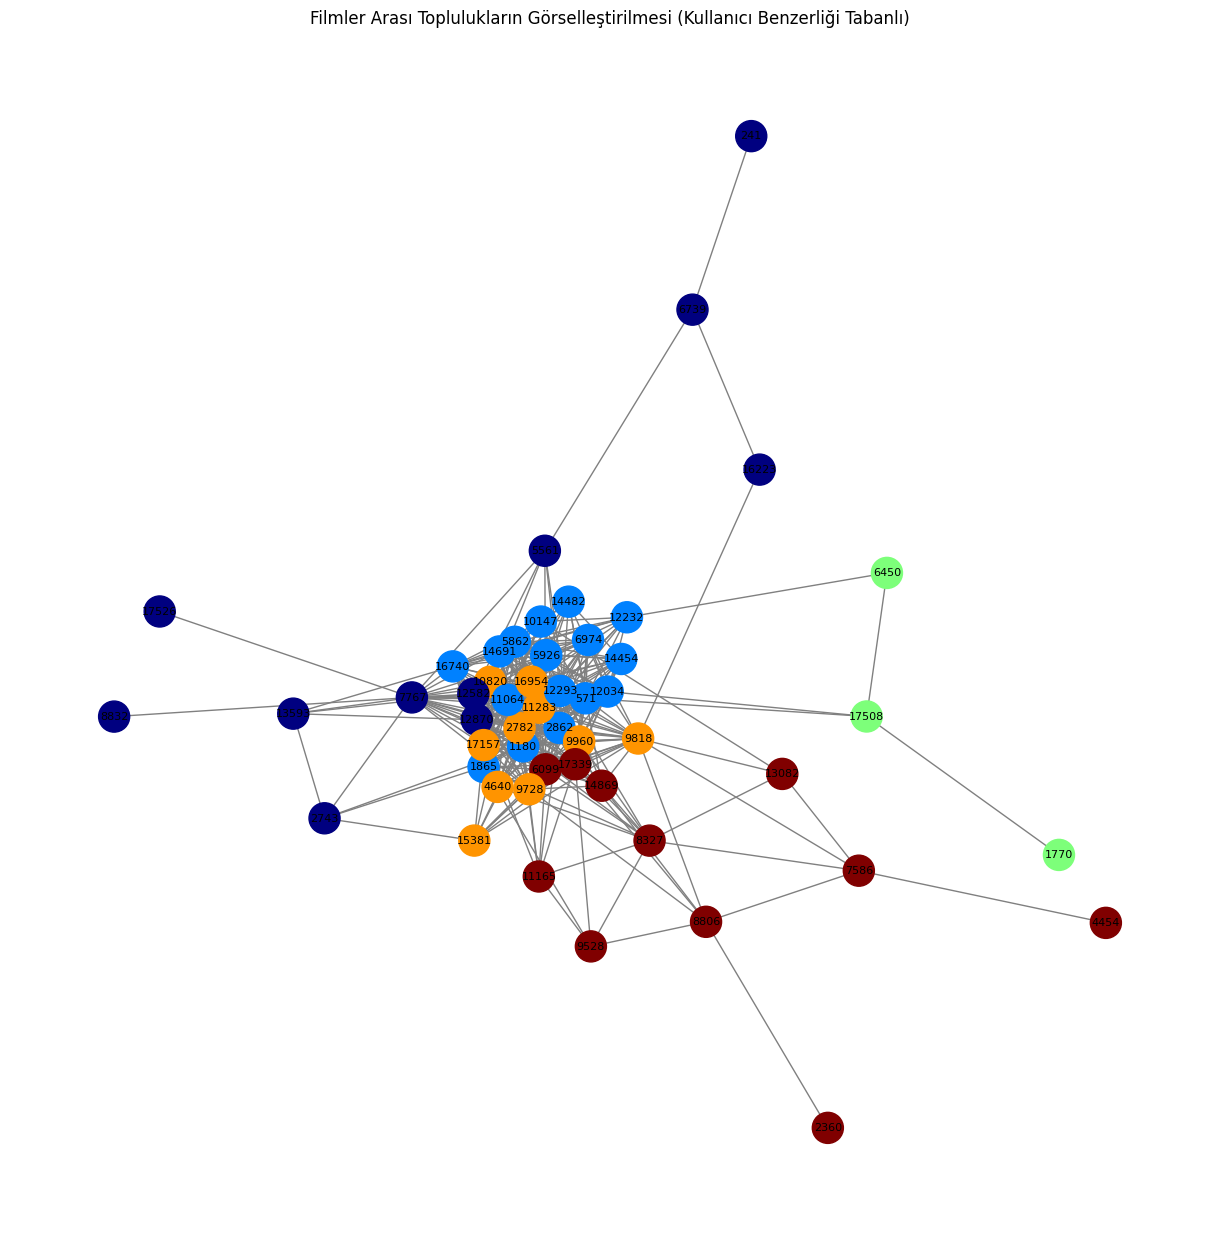

In [ ]:
# Filmler arası benzerlik matrisini bir graf yapısına dönüştürüyoruz
G_movies = nx.Graph()

# Benzerlik değerlerine göre kenarları ekliyoruz
num_movies = len(user_movie_matrix.columns)
for i in range(num_movies):
    for j in range(i+1, num_movies):
        similarity_score = movie_similarity[i, j]
        if similarity_score > 0.5:  # Benzerlik eşiği (bu eşiği ayarlayabilirsiniz)
            G_movies.add_edge(user_movie_matrix.columns[i], user_movie_matrix.columns[j], weight=similarity_score)

# Louvain algoritması ile toplulukları bulma
partition = community_louvain.best_partition(G_movies)

# Toplulukları renklerle ayırt edelim
def draw_movie_communities(G_movies, partition):
    # Topluluklar için renkler
    color_map = {}
    for node, community_id in partition.items():
        color_map[node] = community_id

    # Düğüm yerleşimi (spring layout)
    pos = nx.spring_layout(G_movies, seed=42)  # Yerleşim metodunu buraya uyguluyoruz

    # Düğümleri çiz
    node_colors = [color_map[node] for node in G_movies.nodes()]
    plt.figure(figsize=(12, 12))
    nx.draw(G_movies, pos, node_size=500, node_color=node_colors, with_labels=True, font_size=8, cmap=plt.cm.jet, edge_color="gray")

    # Başlık ve gösterim
    plt.title("Filmler Arası Toplulukların Görselleştirilmesi (Kullanıcı Benzerliği Tabanlı)")
    plt.show()

# Filmler arasındaki toplulukları görselleştir
draw_movie_communities(G_movies, partition)





In [ ]:
def calculate_modularity(G, partition):
    m = G.size(weight='weight')  # Toplam kenar ağırlığı
    modularity = 0

    # Topluluklar arasında döngü yap
    for community in set(partition.values()):
        community_nodes = [node for node, comm in partition.items() if comm == community]

        # Topluluk içindeki kenarları ve dışındaki kenarları incele
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                node_i = community_nodes[i]
                node_j = community_nodes[j]
                weight_ij = G[node_i][node_j]['weight'] if G.has_edge(node_i, node_j) else 0
                k_i = G.degree(node_i, weight='weight')
                k_j = G.degree(node_j, weight='weight')
                modularity += weight_ij - (k_i * k_j) / (2 * m)

    # Modularity formülünde 2m ile çarpıyoruz
    modularity /= (2 * m)

    return modularity

# Modularity hesapla
Q = calculate_modularity(G_movies, partition)
print(f"Modularity (Q) değeri: {Q}")

Modularity (Q) değeri: 0.08160670165011602



Modularity (Q) değeri 0.08, toplulukların ağda belirgin olmadığını ve gruplar arasındaki etkileşimin yüksek olduğunu gösteriyor. Bu düşük değer, filmler arasındaki toplulukların zayıf ve gevşek olduğunu belirtir.

Q = 0: Hiçbir topluluk yapısı yok, ağda topluluklar arasındaki bağlantılar homojen dağılmış.
Q > 0: Ağda topluluk yapıları var, ancak bu yapılar zayıf olabilir ve topluluklar arasındaki geçişler yüksek olabilir.
Q > 0.3: Güçlü topluluk yapıları var, topluluklar arasında geçişler çok daha azdır.
Q ≈ 1: Ağda çok güçlü ve belirgin topluluk yapıları var, topluluklar arasındaki geçişler neredeyse yok

In [ ]:
# 1659478 ID'li kullanıcı ile diğer kullanıcılar arasındaki benzerlikleri bul
user_id = 1659478
user_index = user_movie_matrix.index.get_loc(user_id)

# kullanıcının benzerlik skorlarını al
user_similarity_x =user_similarity[user_index]

# Kendini çıkar (kendisine ait benzerlik skorunu -1 yap)
user_similarity_x[user_index] = -1

# Ağırlıklı benzerlikleri daha da netleştirmek için, her film puanı üzerinde işlem yapabiliriz. Örneğin:
# Örneğin, sıralama (Rank) değerlerine göre her bir kullanıcı için benzerlik hesaplanırken daha yüksek puanlar daha büyük ağırlık taşıyacak

# En benzer kullanıcıyı bul (benzerlik skorları içinde en yüksek değeri bul)
most_similar_user_index = np.argmax(user_similarity_x)  # En yüksek benzerlik skorunun indeksi
most_similar_user_id = user_movie_matrix.index[most_similar_user_index]  # Bu indekse karşılık gelen UserID

# Sonuçları yazdır
print(f"Kullanıcı {user_id} ile diğer kullanıcılar arasındaki Cosine Similarity skorları (kendisi hariç):")
print(user_similarity_x)

# En benzer kullanıcıyı ve benzerlik skorunu yazdır
print(f"Kullanıcı {user_id} ile en benzer olan kullanıcı ID'si: {most_similar_user_id}")
print(f"En Benzerlik Skoru: {user_similarity_x[most_similar_user_index]}")


Kullanıcı 1659478 ile diğer kullanıcılar arasındaki Cosine Similarity skorları (kendisi hariç):
[ 0.6302486   0.11757927  0.33314127  0.44952934  0.65334377  0.4895951
  0.15677236  0.38900699  0.85432058  0.15774914  0.52861877  0.11757927
  0.36093345  0.7312541   0.71137302  0.69086255  0.23947374  0.27435163
  0.76423385  0.62789735  0.35055365  0.15677236  0.19596545  0.61907523
  0.18688506  0.5350842   0.36776324  0.13325651  0.26886238  0.1939959
  0.21033219  0.35757546  0.25600819  0.41294129  0.32001024  0.29103143
  0.43272921  0.66446104  0.2150899   0.43177806  0.15677236  0.44717014
  0.44778182  0.3419625   0.66079632  0.4029298  -1.          0.10082339
  0.76387827  0.15677236  0.55478862  0.15677236  0.27016281  0.33326776
  0.07838618  0.74166358  0.          0.1662822   0.68738111  0.29358107
  0.          0.15677236  0.79855546  0.2150899   0.35663163  0.74279643
  0.59247358  0.21033219  0.43243875  0.40499526  0.26994508  0.37845465
  0.42479909  0.25968916  0.22

In [ ]:
# Kullanıcı kümeleme sonuçlarından topluluk seçimi
random_community = random.choice(communities)

# Rastgele iki kullanıcı seçimi
random_users = random.sample(random_community, 2)
user_a, user_b = random_users

print(f"Seçilen kullanıcılar:")
print({user_a})
print({user_b})

# Kullanıcıların izledikleri filmleri filtreleme
user_a_movies = sampled_data[sampled_data["UserID"] == user_a]
user_b_movies = sampled_data[sampled_data["UserID"] == user_b]

# Kullanıcının izlediği ve beğendiği filmleri elde etme
user_a_liked_movies = user_a_movies[user_a_movies["Rank"] >= 4]  # Örneğin, 4 veya üstü beğenilmiş sayılıyor
user_b_liked_movies = user_b_movies[user_b_movies["Rank"] >= 4]

# Kullanıcı A'nın izlediği ancak Kullanıcı B'nin izlemediği filmleri belirleme
user_b_movie_ids = set(user_b_movies["MovieID"])
recommendable_movies = user_a_liked_movies[~user_a_liked_movies["MovieID"].isin(user_b_movie_ids)]

# Filmleri puana (Rank) göre sıralama
recommended_movies_sorted = recommendable_movies.sort_values(by="Rank", ascending=False)

# Öneri çıktısı
print("Kullanıcı B'ye önerilebilecek filmler (Community-based):")
print(recommended_movies_sorted[["MovieID"]].reset_index(drop=True))


Seçilen kullanıcılar: 1562110, 2059852
Kullanıcı B'ye önerilebilecek filmler (Community-based):
   MovieID  Rank
0     2743     5


In [ ]:
# Kullanıcılar arasındaki benzerliği bir DataFrame'e dönüştür
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Kullanıcılar arası benzerlik matrisinin alt üçgenini alıyoruz (simetrik olduğu için üst kısmı gereksiz)
similarity_matrix_lower_triangle = np.tril(user_similarity, k=-1)

# En yüksek benzerlik değerinin indekslerini buluyoruz
max_similarity_index = np.unravel_index(np.argmax(similarity_matrix_lower_triangle), similarity_matrix_lower_triangle.shape)
user_1_index = max_similarity_index[0]
user_2_index = max_similarity_index[1]

# Kullanıcı ID'lerini indekslerden alıyoruz
most_similar_user_1 = user_similarity_df.index[user_1_index]
most_similar_user_2 = user_similarity_df.index[user_2_index]


# En yüksek benzerlik değerini alıyoruz
max_similarity_value = user_similarity[user_1_index, user_2_index]

print(f"En çok benzeyen iki kullanıcı: {most_similar_user_1} ve {most_similar_user_2}")
print(f"Benzerlik değeri: {max_similarity_value}")



En çok benzeyen iki kullanıcı: 2127527 ve 799006
Benzerlik değeri: 1.0


In [ ]:
# Kullanıcı ID'leri
user_id_1 = 2127527
user_id_2 = 799006

# Kullanıcıların indexlerini bul
try:
    user_1_index = user_movie_matrix.index.get_loc(user_id_1)
    user_2_index = user_movie_matrix.index.get_loc(user_id_2)
except KeyError as e:
    print(f"Error: One or both of the specified UserIDs not found in the user_movie_matrix index: {e}")
    exit()

# Kullanıcıların pivot table satırlarını yazdır
print(f"Pivot table satırı for UserID {user_id_1}:\n{user_movie_matrix.iloc[user_1_index]}")
print(f"\nPivot table satırı for UserID {user_id_2}:\n{user_movie_matrix.iloc[user_2_index]}")

Pivot table satırı for UserID 2127527:
MovieID
241      0.0
471      0.0
571      0.0
1180     0.0
1367     0.0
1595     0.0
1770     0.0
1865     0.0
2360     0.0
2743     0.0
2782     0.0
2862     0.0
4454     0.0
4640     0.0
5561     0.0
5862     0.0
5926     0.0
6099     0.0
6450     0.0
6739     0.0
6974     0.0
7586     0.0
7767     0.0
8327     0.0
8806     0.0
8832     0.0
9528     0.0
9728     0.0
9818     0.0
9960     0.0
10147    0.0
10820    0.0
11064    0.0
11165    0.0
11283    0.0
12034    0.0
12232    0.0
12293    0.0
12582    0.0
12870    0.0
13082    0.0
13593    0.0
14454    0.0
14482    0.0
14691    0.0
14869    0.0
15366    0.0
15381    0.0
16223    0.0
16740    0.0
16954    5.0
17157    0.0
17339    0.0
17508    0.0
17526    0.0
Name: 2127527, dtype: float64

Pivot table satırı for UserID 799006:
MovieID
241      0.0
471      0.0
571      0.0
1180     0.0
1367     0.0
1595     0.0
1770     0.0
1865     0.0
2360     0.0
2743     0.0
2782     0.0
2862     0.0
4454 

yukarıdaki benzerliğin nedeni ikisi de tek film izlemiş ve o filme 5 puan vermiş


**recommender** **code**

In [ ]:
# Kullanıcılar arasındaki benzerliği DataFrame'e dönüştür
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Filmler arasındaki benzerliği DataFrame'e dönüştür
item_similarity_df = pd.DataFrame(item_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Kullanıcı bazlı tavsiye fonksiyonu
def user_based_recommendation(user_id, user_similarity_df, user_movie_matrix, top_n=5):
    user_idx = user_movie_matrix.index.get_loc(user_id)

    # Kullanıcı ile diğer kullanıcılar arasındaki benzerliği al
    similar_users = user_similarity_df.iloc[user_idx]

    # Kullanıcıyla en çok benzeyen kullanıcıları al
    similar_users = similar_users.sort_values(ascending=False).iloc[1:]  # Kendisi hariç
    similar_users = similar_users.head(top_n)

    recommended_movies = []
    for similar_user in similar_users.index:
        user_ratings = user_movie_matrix.loc[similar_user]
        for movie_id, rating in user_ratings.items():
            if rating > 0 and movie_id not in user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index:
                recommended_movies.append((movie_id, rating))

    recommended_movies = sorted(recommended_movies, key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [movie[0] for movie in recommended_movies[:top_n]]

    return recommended_movie_ids

# Film bazlı tavsiye fonksiyonu
def item_based_recommendation(movie_id, item_similarity_df, user_movie_matrix, top_n=5):
    movie_idx = user_movie_matrix.columns.get_loc(movie_id)

    # Film ile diğer filmler arasındaki benzerliği al
    similar_items = item_similarity_df.iloc[movie_idx]

    # Filmiyle en çok benzeyen diğer filmleri al
    similar_items = similar_items.sort_values(ascending=False).iloc[1:]  # Kendisi hariç
    similar_items = similar_items.head(top_n)

    recommended_movies = []
    for similar_movie_id, similarity in similar_items.items():
        if user_movie_matrix[movie_id].sum() > 0:  # Eğer film puanlanmışsa
            recommended_movies.append((similar_movie_id, similarity))

    recommended_movies = sorted(recommended_movies, key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [movie[0] for movie in recommended_movies[:top_n]]

    return recommended_movie_ids

# Kullanıcı bazlı tavsiye (UserID parametreli)
user_id = 2127527  # Kullanıcı ID'si
recommended_movie_ids_user_based = user_based_recommendation(user_id, user_similarity_df, user_movie_matrix)

# Film bazlı tavsiye (MovieID parametreli)
movie_id = 12870  # Film ID'si (Schindler's List)
recommended_movie_ids_item_based = item_based_recommendation(movie_id, item_similarity_df, user_movie_matrix)

# Sonuçları yazdırmak için title'ları alalım
movie_titles = {movie_id: title for movie_id, title in zip(sampled_data['MovieID'], sampled_data['title'])}

# Kullanıcı bazlı tavsiye edilen filmler
print(f"Kullanıcı {user_id} için önerilen filmler (User-based):")
for movie_id in recommended_movie_ids_user_based:
    print(movie_titles[movie_id])

# Film bazlı tavsiye edilen filmler
print(f"\nFilm {movie_id} için önerilen filmler (Item-based):")
for movie_id in recommended_movie_ids_item_based:
    print(movie_titles[movie_id])

Kullanıcı 2127527 için önerilen filmler (User-based):
Apocalypse Now
Braveheart
Forrest Gump
Schindler's List
Saving Private Ryan

Film 17157 için önerilen filmler (Item-based):
O Brother, Where Art Thou?
The Silence of the Lambs
Indiana Jones and the Last Crusade
Mystic River
Braveheart


In [ ]:
#homofili hesabı , benzer beğeniler
# Kullanıcıların verdiği yüksek puanları 4 ve üstü kabul edebiliriz (bu eşiği değiştirebilirsiniz)
high_rating_threshold = 4

# Filmler arasındaki ilişkiyi tutacak bir sözlük oluşturuyoruz
movie_relationship = {}

# sampled_data'dan her bir kullanıcı ve verdiği filmi alalım
for _, row in sampled_data.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    rating = row['Rank']

    # Kullanıcıların yüksek puan verdiği filmleri filtrele
    if rating >= high_rating_threshold:
        if movie_id not in movie_relationship:
            movie_relationship[movie_id] = set()
        movie_relationship[movie_id].add(user_id)

# Filmler arasındaki ilişkiyi hesaplayalım
film_similarities = {}

# Filmler arasındaki kullanıcı kesişimini hesaplayalım
for movie_id1 in movie_relationship:
    for movie_id2 in movie_relationship:
        if movie_id1 != movie_id2:
            # Ortak kullanıcıları buluyoruz
            common_users = movie_relationship[movie_id1].intersection(movie_relationship[movie_id2])
            if common_users:
                if (movie_id1, movie_id2) not in film_similarities and (movie_id2, movie_id1) not in film_similarities:
                    film_similarities[(movie_id1, movie_id2)] = len(common_users)

# En fazla benzer kullanıcıya sahip ilk 5 filmi bulalım
sorted_film_similarities = sorted(film_similarities.items(), key=lambda x: x[1], reverse=True)

# sampled_data'dan başlıkları almak için
movie_titles = {row['MovieID']: row['title'] for _, row in sampled_data.iterrows()}

# En fazla benzer kullanıcılar tarafından izlenmiş ve puanlanmış 5 film (topluluk analiziyle):
print("En fazla benzer kullanıcılar tarafından izlenmiş ve puanlanmış 5 film (topluluk analiziyle):")
for (movie_id1, movie_id2), similarity_score in sorted_film_similarities[:5]:
    title1 = movie_titles.get(movie_id1, "Bilinmeyen Film")
    title2 = movie_titles.get(movie_id2, "Bilinmeyen Film")

    # Ortak kullanıcıları bul
    common_users = movie_relationship[movie_id1].intersection(movie_relationship[movie_id2])

    # Topluluk dağılımlarını hesapla
    community_distribution = {0: 0, 1: 0, 2: 0}  # Topluluklar için başlangıç dağılımı
    for user in common_users:
        for community_id, members in communities.items():
            if user in members:  # Kullanıcı hangi toplulukta bulunuyorsa
                community_distribution[community_id] += 1

    # Topluluk dağılımını liste olarak oluştur
    community_distribution_str = ", ".join([f"Topluluk {comm}: {count}" for comm, count in community_distribution.items()])

    print(f"Film 1: {title1}, Film 2: {title2}, Ortak Kullanıcı Sayısı: {similarity_score}")
    print(f"  Topluluk Dağılımı: {community_distribution_str}")


En fazla benzer kullanıcılar tarafından izlenmiş ve puanlanmış 5 film (topluluk analiziyle):
Film 1: Rain Man, Film 2: Forrest Gump, Ortak Kullanıcı Sayısı: 23
  Topluluk Dağılımı: Topluluk 0: 7, Topluluk 1: 10, Topluluk 2: 6
Film 1: Braveheart, Film 2: Forrest Gump, Ortak Kullanıcı Sayısı: 22
  Topluluk Dağılımı: Topluluk 0: 8, Topluluk 1: 9, Topluluk 2: 5
Film 1: American Beauty, Film 2: Pulp Fiction, Ortak Kullanıcı Sayısı: 20
  Topluluk Dağılımı: Topluluk 0: 9, Topluluk 1: 1, Topluluk 2: 10
Film 1: Forrest Gump, Film 2: Indiana Jones and the Last Crusade, Ortak Kullanıcı Sayısı: 20
  Topluluk Dağılımı: Topluluk 0: 8, Topluluk 1: 6, Topluluk 2: 6
Film 1: Pulp Fiction, Film 2: The Matrix, Ortak Kullanıcı Sayısı: 19
  Topluluk Dağılımı: Topluluk 0: 5, Topluluk 1: 2, Topluluk 2: 12


In [ ]:
# Örneğin, belirli bir topluluktan film seçelim
selected_community = 0  # Örneğin, topluluk 0'ı seçelim
selected_movies_in_community = [movie for movie, community_id in partition.items() if community_id == selected_community]

print(f"Topluluk {selected_community} içindeki filmler: {selected_movies_in_community}")

Topluluk 0 içindeki filmler: [241, 6739, 7767, 2743, 13593, 5561, 16223, 8832, 17526]


In [ ]:
# Graf oluşturma (Kullanıcı-Kullanıcı ağı)
G = nx.Graph()
num_users = len(user_movie_matrix)

for i in range(num_users):
    for j in range(i + 1, num_users):
        similarity_score = user_similarity[i, j]
        if similarity_score > 0.55:  # Eşik değeri
            G.add_edge(user_movie_matrix.index[i], user_movie_matrix.index[j], weight=similarity_score)

# Topluluk algılama (Girvan-Newman)
from networkx.algorithms.community import girvan_newman
communities = list(girvan_newman(G))
communities = communities[0]  # İlk topluluğu seçiyoruz

# Düğüm için Clustering Coefficient hesaplama
def calculate_cc(graph, node):
    # Düğümün komşularını al
    neighbors = list(graph.neighbors(node))

    # Komşular arasındaki bağlantıları kontrol et
    total_neighbors = len(neighbors)
    connected_neighbors = 0

    for i in range(total_neighbors):
        for j in range(i + 1, total_neighbors):
            if graph.has_edge(neighbors[i], neighbors[j]):
                connected_neighbors += 1

    # Clustering Coefficient hesaplama
    if total_neighbors > 1:
        cc = connected_neighbors / (total_neighbors * (total_neighbors - 1) / 2)
    else:
        cc = 0  # Bir komşu varsa CC sıfır kabul edilir

    return cc

# Örnek bir düğüm seç (grafın ilk düğümü)
selected_node = list(G.nodes())[0]

# Düğümün CC değerini hesapla
cc_value = calculate_cc(G, selected_node)
print(f"Düğüm {selected_node} için Clustering Coefficient: {cc_value:.4f}")


Düğüm 48378 için Clustering Coefficient: 0.9818


In [ ]:
# Graf oluşturma (Kullanıcı-Kullanıcı ağı)
G = nx.Graph()
num_users = len(user_movie_matrix)

for i in range(num_users):
    for j in range(i + 1, num_users):
        similarity_score = user_similarity[i, j]
        if similarity_score > 0.55:  # Eşik değeri
            G.add_edge(user_movie_matrix.index[i], user_movie_matrix.index[j], weight=similarity_score)

# Clustering Coefficient hesaplama fonksiyonu
def calculate_cc(graph, node):
    # Düğümün komşularını al
    neighbors = list(graph.neighbors(node))

    # Komşular arasındaki bağlantıları kontrol et
    total_neighbors = len(neighbors)
    connected_neighbors = 0

    for i in range(total_neighbors):
        for j in range(i + 1, total_neighbors):
            if graph.has_edge(neighbors[i], neighbors[j]):
                connected_neighbors += 1

    # Clustering Coefficient hesaplama
    if total_neighbors > 1:
        cc = connected_neighbors / (total_neighbors * (total_neighbors - 1) / 2)
    else:
        cc = 0  # Bir komşu varsa CC sıfır kabul edilir

    return cc

# Tüm düğümler için CC hesaplama
print("Her bir düğüm için Clustering Coefficient değerleri:")
cc_results = {}  # Sonuçları saklamak için bir sözlük
for node in G.nodes():
    cc_value = calculate_cc(G, node)
    cc_results[node] = cc_value
    print(f"Düğüm {node} için CC: {cc_value:.4f}")

# İsterseniz CC sonuçlarını bir DataFrame'e kaydedebilirsiniz
import pandas as pd
cc_df = pd.DataFrame(list(cc_results.items()), columns=["Node", "Clustering Coefficient"])


Her bir düğüm için Clustering Coefficient değerleri:
Düğüm 48378 için CC: 0.9818
Düğüm 270356 için CC: 0.7810
Düğüm 396942 için CC: 0.6797
Düğüm 524869 için CC: 0.7647
Düğüm 1467952 için CC: 0.4901
Düğüm 1659478 için CC: 0.6623
Düğüm 1689793 için CC: 0.5200
Düğüm 1943647 için CC: 0.6206
Düğüm 2127544 için CC: 0.7778
Düğüm 2579654 için CC: 0.8667
Düğüm 2622042 için CC: 0.8286
Düğüm 2646107 için CC: 0.6797
Düğüm 50353 için CC: 0.0000
Düğüm 430681 için CC: 0.0000
Düğüm 113184 için CC: 0.0000
Düğüm 1603632 için CC: 0.2381
Düğüm 538673 için CC: 0.6211
Düğüm 881085 için CC: 0.9444
Düğüm 2228059 için CC: 0.6619
Düğüm 2321284 için CC: 1.0000
Düğüm 322797 için CC: 0.3333
Düğüm 616006 için CC: 0.6750
Düğüm 1629226 için CC: 0.8022
Düğüm 2059852 için CC: 0.7879
Düğüm 328312 için CC: 0.8000
Düğüm 1258460 için CC: 1.0000
Düğüm 1434132 için CC: 0.3571
Düğüm 1901511 için CC: 0.5238
Düğüm 2541279 için CC: 0.4286
Düğüm 2603301 için CC: 0.8000
Düğüm 742858 için CC: 0.9011
Düğüm 754670 için CC: 0.8791
Düğ

*Örneğin, düğümler 2321284, 1258460, ve 971912 gibi düğümlerin CC değerleri 1.0'a çok yakın veya tam 1.0.
Bu, bu düğümlerin komşularının tamamen birbirine bağlı olduğu anlamına gelir. Bu düğümler, bir tür tam bağlı alt ağ (clique) içinde yer alıyor olabilir.

*Örneğin, düğümler 48378, 742858, ve
2541279 orta düzeyde bir bağlanma
gösteriyor.
Bu, bu düğümlerin komşularının birbirleriyle bağlantılı olduğunu, ancak bu bağlantının tam olmadığını ifade eder.

*Bu, grafınızda yaygın bir durum gibi görünüyor. Örneğin, düğüm 1451666 ve diğer birçok düğümün CC değeri sıfır.
Bu durum, bu düğümlerin komşularının birbirleriyle bağlantılı olmaması durumundan kaynaklanır. Bu düğümler, grafınızda yalnız düğümler gibi davranıyor olabilir veya bu düğümler topluluklar arasındaki bağlantılarda yer alıyordur.

In [ ]:
# PageRank hesaplaması (tüm düğümler için)
pagerank_values = nx.pagerank(G_movies, weight='weight')

# Her topluluk için PageRank hesaplama
community_pagerank = {}

# Her topluluk için PageRank değerlerini toplayalım
for community_id in set(partition.values()):
    community_nodes = [node for node, comm_id in partition.items() if comm_id == community_id]

    # Topluluktaki her düğüm için PageRank değeri
    community_pagerank[community_id] = {node: pagerank_values[node] for node in community_nodes}

# Her topluluk için PageRank değerlerini yazdırma
for community_id, pr_values in community_pagerank.items():
    print(f"Topluluk {community_id} için PageRank değerleri:")
    for node, pr_value in pr_values.items():
        print(f"{node}: {pr_value:.4f}")

Topluluk 0 için PageRank değerleri:
241: 0.0078
6739: 0.0140
7767: 0.0325
2743: 0.0082
13593: 0.0084
5561: 0.0121
16223: 0.0074
8832: 0.0039
17526: 0.0041
Topluluk 1 için PageRank değerleri:
571: 0.0353
1865: 0.0249
5862: 0.0267
5926: 0.0259
10147: 0.0146
11064: 0.0310
12034: 0.0303
12232: 0.0166
14454: 0.0179
14482: 0.0133
14691: 0.0243
16740: 0.0231
17508: 0.0122
1770: 0.0057
6450: 0.0065
Topluluk 2 için PageRank değerleri:
1180: 0.0359
6099: 0.0275
17339: 0.0331
8327: 0.0168
11165: 0.0105
14869: 0.0170
15381: 0.0122
9528: 0.0089
2360: 0.0047
8806: 0.0146
4454: 0.0053
7586: 0.0143
13082: 0.0093
Topluluk 3 için PageRank değerleri:
2782: 0.0283
2862: 0.0298
4640: 0.0207
6974: 0.0179
9728: 0.0270
9818: 0.0307
9960: 0.0268
10820: 0.0232
11283: 0.0319
12293: 0.0295
12582: 0.0299
12870: 0.0335
16954: 0.0258
17157: 0.0278


Topluluk 0: 12870 (0.0335) ve 7767 (0.0325) öne çıkıyor, diğer düğümlerden daha etkili.
Topluluk 1: 17508 (0.0122) en yüksek değere sahip, ancak genel olarak değerler düşük.
Topluluk 2: 1180 (0.0359) ve 571 (0.0353) dikkat çekiyor, bu topluluk içinde güçlü düğümler var.
Topluluk 3: 11283 (0.0319) en yüksek değeri almış, birkaç düğüm birbirine yakın yüksek değerlerde.
Topluluk 4: 17339 (0.0331) öne çıkıyor, genel değerler orta seviyede.
Her toplulukta yüksek PageRank değerine sahip düğümler, o topluluğun merkezi ve önemli aktörlerini temsil ediyor.

In [ ]:
def divrank(graph, alpha=0.85, max_iter=100, tol=1e-6):
    # Toplam düğüm sayısı
    nodes = list(graph.nodes())
    n = len(nodes)
    if n == 0:
        return {}

    # Adjacency matrix (Komşuluk matrisi)
    adj_matrix = nx.to_numpy_array(graph, nodelist=nodes)

    # Normalize adjacency matrix to create transition probabilities
    row_sums = adj_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Bölme hatalarını önlemek için
    transition_matrix = adj_matrix / row_sums

    # Personalized teleport vector
    teleport = np.ones(n) / n

    # Initialize scores
    scores = np.ones(n) / n

    for iteration in range(max_iter):
        new_scores = alpha * np.dot(transition_matrix.T, scores) + (1 - alpha) * teleport
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores

    return {nodes[i]: scores[i] for i in range(n)}

In [ ]:
# DivRank fonksiyonunu yukarıdaki gibi tanımlayın.

# Her topluluk için DivRank hesaplama
community_divrank = {}

for community_id in set(partition.values()):
    community_nodes = [node for node, comm_id in partition.items() if comm_id == community_id]
    community_subgraph = G_movies.subgraph(community_nodes)

    # Topluluk için DivRank hesapla
    community_divrank[community_id] = divrank(community_subgraph, alpha=0.85, max_iter=100, tol=1e-6)

# Her topluluk için DivRank değerlerini yazdırma
for community_id, divrank_values in community_divrank.items():
    print(f"Topluluk {community_id} için DivRank değerleri:")
    for node, score in divrank_values.items():
        print(f"{node}: {score:.4f}")


Topluluk 0 için DivRank değerleri:
8832: 0.0538
7767: 0.2509
5561: 0.1056
241: 0.0779
6739: 0.1789
17526: 0.0626
2743: 0.0988
13593: 0.1120
16223: 0.0596
Topluluk 1 için DivRank değerleri:
12034: 0.0818
10147: 0.0525
14691: 0.0808
16740: 0.0680
5926: 0.0748
5862: 0.0886
12232: 0.0835
1865: 0.0626
17508: 0.0518
1770: 0.0218
14482: 0.0571
6450: 0.0271
14454: 0.0573
11064: 0.0909
571: 0.1014
Topluluk 2 için DivRank değerleri:
2360: 0.0266
7586: 0.0940
8806: 0.0928
8327: 0.1249
4454: 0.0302
6099: 0.0986
14869: 0.0793
15381: 0.0512
9528: 0.0653
13082: 0.0488
17339: 0.1240
1180: 0.0911
11165: 0.0732
Topluluk 3 için DivRank değerleri:
9728: 0.0722
4640: 0.0677
10820: 0.0720
12293: 0.0659
12582: 0.0741
12870: 0.0742
9960: 0.0701
17157: 0.0706
2862: 0.0750
6974: 0.0497
11283: 0.0787
16954: 0.0749
9818: 0.0746
2782: 0.0804


Topluluk 0: 7767 (2.1940) en yüksek değere sahip, onu 6739 (1.3155) ve 5561 (1.3028) izliyor.
Topluluk 1: 17508 (1.4595) öne çıkıyor, diğer değerler ise daha düşük.
Topluluk 2: 12034 (1.0996) ve 5862 (1.2578) gibi güçlü düğümler var, birçok düğüm ortalama seviyede.
Topluluk 3: 11283 (1.0879) ve 9818 (1.0879) gibi düğümler yüksek değerlere sahip.
Topluluk 4: 8327 (1.7015) ve 17339 (1.4248) dikkat çekiyor, çoğu düğüm orta seviyede.
DivRank, her düğümün topluluk içindeki önemini ve merkeziyetini belirliyor.